In [1]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
import pathlib
import time
import datetime
from IPython import display

2025-09-21 21:59:40.008770: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758491980.247546      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758491980.317412      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# List top-level contents
print(os.listdir('/kaggle/input/celebahq-resized-256x256'))

['celeba_hq_256']


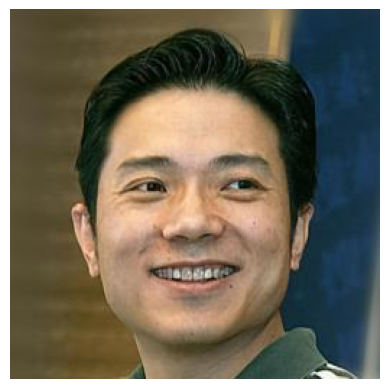

In [3]:
img_path = '/kaggle/input/celebahq-resized-256x256/celeba_hq_256/00000.jpg'
img = Image.open(img_path)
plt.imshow(img)
plt.axis('off')
plt.show()

In [4]:
sample_image = tf.io.read_file(str('/kaggle/input/celebahq-resized-256x256/celeba_hq_256/00004.jpg'))
sample_image = tf.io.decode_jpeg(sample_image)
print(sample_image.shape)

(256, 256, 3)


I0000 00:00:1758491995.068031      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758491995.068691      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


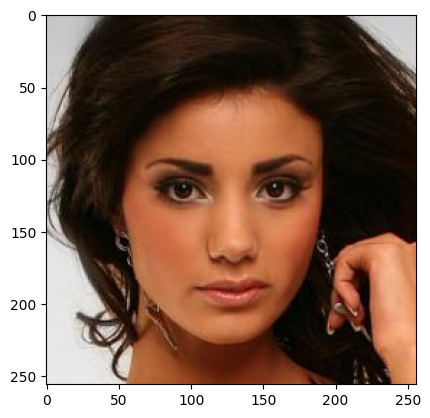

In [5]:
plt.figure()
plt.imshow(sample_image)

### **Disabling Mixed Precision**

In [6]:
from tensorflow.keras import mixed_precision

# Set policy to  precision
mixed_precision.set_global_policy('float32')

print('Compute dtype:', tf.keras.mixed_precision.global_policy())

Compute dtype: <DTypePolicy "float32">


### **Image Corruption Module**

In [7]:
import os
import cv2
import numpy as np
import random
from PIL import Image
from tqdm import tqdm

# Clean image source directory
clean_dir = '/kaggle/input/celebahq-resized-256x256/celeba_hq_256'
# Degraded images output directory
degraded_dir = '/kaggle/working/degraded'
os.makedirs(degraded_dir, exist_ok=True)

limit = None  # or 10000
images = sorted(os.listdir(clean_dir))[:limit]

In [8]:
np.random.seed(42)

In [9]:
# Define degradation functions

def add_gaussian_noise(image, mean=0, std=25):
    noise = np.random.normal(mean, std, image.shape).astype(np.float32)
    noisy_img = image.astype(np.float32) + noise
    return np.clip(noisy_img, 0, 255).astype(np.uint8)

def add_motion_blur(image, kernel_size=15):
    kernel = np.zeros((kernel_size, kernel_size))
    kernel[int((kernel_size - 1)/2), :] = np.ones(kernel_size)
    kernel = kernel / kernel_size
    blurred = cv2.filter2D(image, -1, kernel)
    return blurred

def add_occlusion(image, num_blocks=5):
    h, w, _ = image.shape
    for _ in range(num_blocks):
        x = random.randint(0, w - 50)
        y = random.randint(0, h - 50)
        bw = random.randint(20, 50)
        bh = random.randint(20, 50)
        image[y:y+bh, x:x+bw] = random.randint(0, 255)
    return image

def jpeg_compression(image, quality=15):
    encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), quality]
    _, encimg = cv2.imencode('.jpg', image, encode_param)
    decimg = cv2.imdecode(encimg, 1)
    return decimg

def random_degradation(image):
    operations = [add_gaussian_noise, add_motion_blur, add_occlusion, jpeg_compression]
    num_ops = random.randint(1, 3)
    chosen = random.sample(operations, num_ops)
    for op in chosen:
        image = op(image)
    return image

def apply_corruption_to_folder(clean_dir, degraded_dir):

    for file in tqdm(images, desc="Corrupting images"):
        img_path = os.path.join(clean_dir, file)
        save_path = os.path.join(degraded_dir, file)

        image = cv2.imread(img_path)
        if image is None:
            continue
        image = cv2.resize(image, (256, 256))  # Optional resize
        degraded = random_degradation(image)
        cv2.imwrite(save_path, degraded, [cv2.IMWRITE_JPEG_QUALITY, 100])

apply_corruption_to_folder(clean_dir, degraded_dir)

Corrupting images: 100%|██████████| 30000/30000 [07:30<00:00, 66.66it/s]


### **Preprocessing the images**

**Define several functions that:**

- Resize each 256 x 256 image to a larger height and width—286 x 286.
- Randomly crop it back to 256 x 256.
- Randomly flip the image horizontally i.e., left to right (random mirroring).
- Normalize the images to the [-1, 1] range.

In [10]:
import tensorflow as tf
import os

IMG_WIDTH = 256
IMG_HEIGHT = 256
BUFFER_SIZE = 10000
BATCH_SIZE = 1

In [11]:
# Preprocessing functions
def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    real_image = tf.image.resize(real_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    return input_image, real_image

def random_crop(input_image, real_image):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(stacked_image, size=[2, IMG_HEIGHT, IMG_WIDTH, 3])
    return cropped_image[0], cropped_image[1]

def normalize(input_image, real_image):
    input_image = tf.clip_by_value(input_image, 0.0, 255.0)
    real_image = tf.clip_by_value(real_image, 0.0, 255.0)
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1
    return input_image, real_image

In [12]:
@tf.function()
def random_jitter(input_image, real_image):
    # Resize to 286x286
    input_image, real_image = resize(input_image, real_image, 286, 286)
    # Random crop back to 256x256
    input_image, real_image = random_crop(input_image, real_image)
    # Random flip
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        real_image = tf.image.flip_left_right(real_image)
    return input_image, real_image

In [13]:
clean_path= '/kaggle/input/celebahq-resized-256x256/celeba_hq_256'
degraded_path= '/kaggle/working/degraded'

In [14]:
# Function to load paired images
def load(degraded_path, clean_path):
    input_image = tf.io.read_file(degraded_path)
    input_image = tf.image.decode_jpeg(input_image)
    input_image = tf.cast(input_image, tf.float32)

    real_image = tf.io.read_file(clean_path)
    real_image = tf.image.decode_jpeg(real_image)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image

In [15]:
# List image filenames (sorted for reproducibility)
limit = None
clean_images = sorted(os.listdir(clean_path))[:limit]  
degraded_images = sorted(os.listdir(degraded_path))[:limit]  

# Split into 8k train and 2k test
train_clean_images = clean_images[:24000]
test_clean_images = clean_images[24000:30000]

train_degraded_images = degraded_images[:24000]
test_degraded_images = degraded_images[24000:30000]

In [16]:
# Load + preprocess training images
def load_image_train(degraded_path, clean_path):
    input_image, real_image = load(degraded_path, clean_path)
    input_image, real_image = random_jitter(input_image, real_image)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image


In [17]:
# Load + preprocess testing images
def load_image_test(degraded_path, clean_path):
    input_image, real_image = load(degraded_path, clean_path)
    input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)
    input_image, real_image = normalize(input_image, real_image)
    return input_image, real_image

**Build TensorFlow Datasets**

In [18]:
import os
assert len(os.listdir(degraded_path)) == len(os.listdir(clean_path)), "Mismatch in degraded/clean images"

In [19]:
# Create training dataset
def load_image_train_tf(degraded_file, clean_file):
    degraded_path_full = tf.strings.join([degraded_path, degraded_file], separator="/")
    clean_path_full = tf.strings.join([clean_path, clean_file], separator="/")
    input_image, real_image = load_image_train(degraded_path_full, clean_path_full)
    return input_image, real_image

train_dataset = tf.data.Dataset.from_tensor_slices((train_degraded_images, train_clean_images))
train_dataset = train_dataset.map(load_image_train_tf, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [20]:
# Create testing dataset
def load_image_test_tf(degraded_file, clean_file):
    degraded_path_full = tf.strings.join([degraded_path, degraded_file], separator="/")
    clean_path_full = tf.strings.join([clean_path, clean_file], separator="/")
    input_image, real_image = load_image_test(degraded_path_full, clean_path_full)
    return input_image, real_image

test_dataset = tf.data.Dataset.from_tensor_slices((test_degraded_images, test_clean_images))
test_dataset = test_dataset.map(load_image_test_tf, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE)

### **Building the Generator**

**The generator of your pix2pix cGAN is a modified U-Net. A U-Net consists of an encoder (downsampler) and decoder (upsampler).**

- Each block in the encoder is: Convolution -> Batch normalization -> Leaky ReLU
- Each block in the decoder is: Transposed convolution -> Batch normalization -> Dropout (applied to the first 3 blocks) -> ReLU
- There are skip connections between the encoder and decoder (as in the U-Net).

### **Downsampler**

In [21]:
# Define the downsampler (encoder):

OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_batchnorm=True):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_batchnorm:
    result.add(tf.keras.layers.BatchNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

**Downsampling the model by passing one image**

In [22]:
degraded_img = '/kaggle/working/degraded/00001.jpg'
clean_img = '/kaggle/input/celebahq-resized-256x256/celeba_hq_256/00001.jpg'

input_image, real_image = load_image_train(degraded_img, clean_img)

In [23]:
down_model = downsample(3, 4)
down_result = down_model(tf.expand_dims(input_image, 0))
print (down_result.shape)

I0000 00:00:1758492448.298448      35 cuda_dnn.cc:529] Loaded cuDNN version 90300


(1, 128, 128, 3)


### **Upsampler**

In [24]:
# Define the upsampler (decoder):

def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
    tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                    padding='same',
                                    kernel_initializer=initializer,
                                    use_bias=False))

  result.add(tf.keras.layers.BatchNormalization())

  if apply_dropout:
      result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [25]:
up_model = upsample(3, 4)
up_result = up_model(down_result)
print (up_result.shape)

(1, 256, 256, 3)


### **Generator**

In [26]:
# Define the generator with the downsampler and the upsampler:

def Generator():
  inputs = tf.keras.layers.Input(shape=[256, 256, 3])

  down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    downsample(512, 4),  # (batch_size, 4, 4, 512)
    downsample(512, 4),  # (batch_size, 2, 2, 512)
    downsample(512, 4),  # (batch_size, 1, 1, 512)
  ]

  up_stack = [
    upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                         strides=2,
                                         padding='same',
                                         kernel_initializer=initializer,
                                         activation='tanh')  # (batch_size, 256, 256, 3)

  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = tf.keras.layers.Concatenate()([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

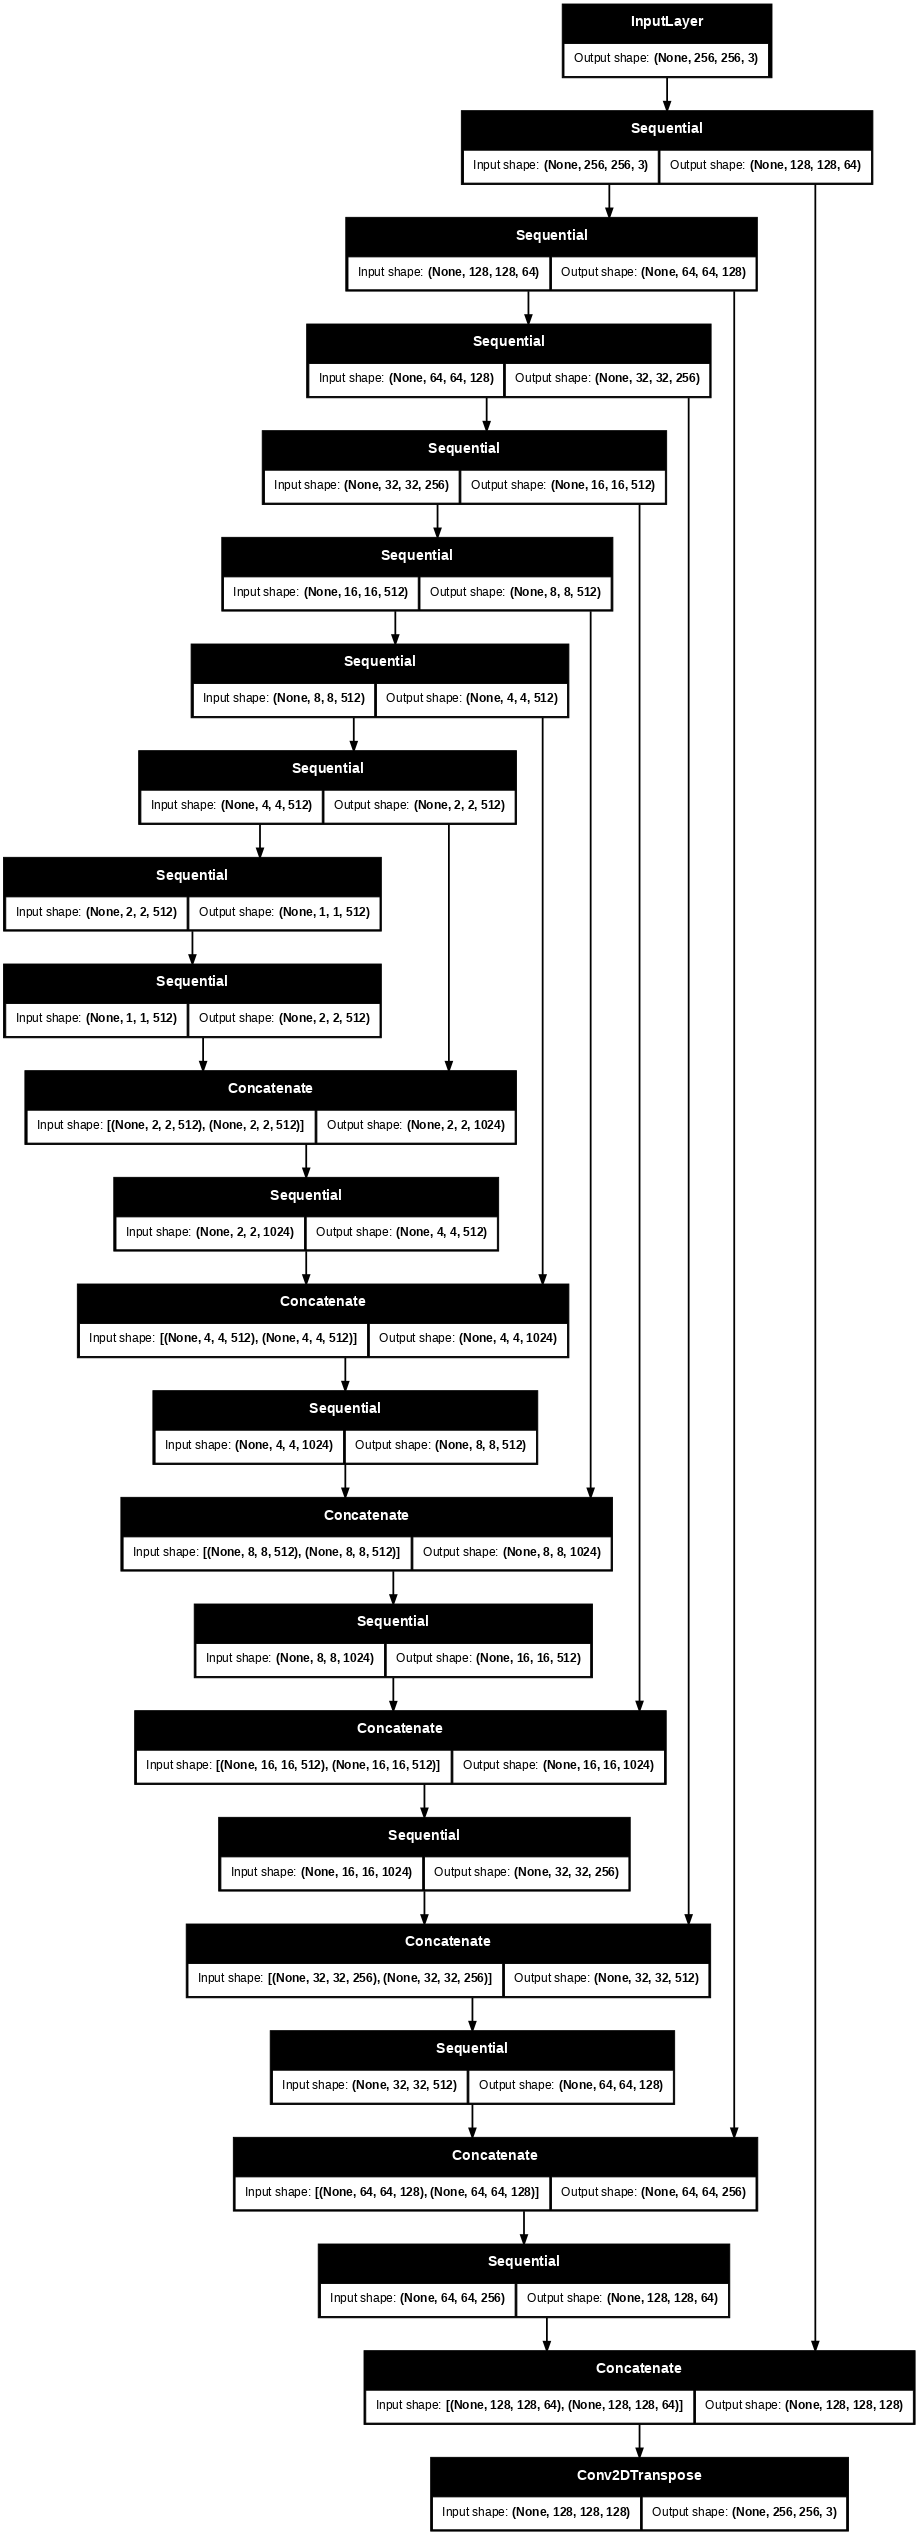

In [27]:
# Visualize the generator model architecture:

generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

### **Testing the Generator Model**

In [28]:
gen_output = generator(input_image[tf.newaxis, ...], training=False)

# Convert tensor to numpy and rescale from [-1, 1] to [0, 1]
output_img = (gen_output[0].numpy() + 1) / 2

print(output_img.shape)    # Should be (H, W, 3)
print(output_img.dtype)   

(256, 256, 3)
float32


In [29]:
print(output_img.min(), output_img.max())

0.4640335 0.5246798


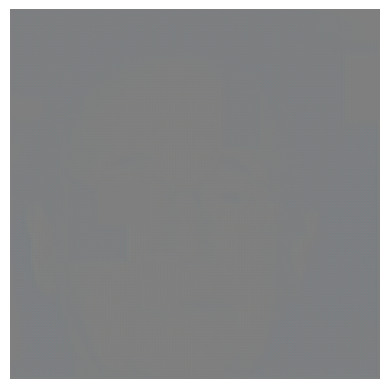

In [30]:
plt.imshow(output_img.astype('float32'))
plt.axis('off')
plt.show()

In [31]:
gen_output = generator(input_image[tf.newaxis, ...], training=False)
print(gen_output.numpy().min(), gen_output.numpy().max())

-0.07193295 0.04935952


### **Define the generator loss**

**GANs learn a loss that adapts to the data, while cGANs learn a structured loss that penalizes a possible structure that differs from the network output and the target image, as described in the pix2pix paper.**

- The generator loss is a sigmoid cross-entropy loss of the generated images and an array of ones.
- The pix2pix paper also mentions the L1 loss, which is a MAE (mean absolute error) between the generated image and the target image.
- This allows the generated image to become structurally similar to the target image.
- The formula to calculate the total generator loss is `gan_loss + LAMBDA * l1_loss`, where `LAMBDA = 100`. This value was decided by the authors of the paper.

In [32]:
LAMBDA = 100

In [33]:
loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [34]:
def generator_loss(disc_generated_output, gen_output, target):
    
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    target = tf.cast(target, gen_output.dtype)  # Make sure same dtype
    
    # Mean absolute error
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))

    total_gen_loss = gan_loss + (LAMBDA * l1_loss)

    return total_gen_loss, gan_loss, l1_loss

### **Build the discriminator**

**The discriminator in the pix2pix cGAN is a convolutional PatchGAN classifier—it tries to classify if each image patch is real or not real, as described in the pix2pix paper.**

- Each block in the discriminator is: Convolution -> Batch normalization -> Leaky ReLU.
- The shape of the output after the last layer is `(batch_size, 30, 30, 1)`.
- Each 30 x 30 image patch of the output classifies a 70 x 70 portion of the input image.
- The discriminator receives 2 inputs:
     - The input image and the target image, which it should classify as real.
     - The input image and the generated image (the output of the generator), which it should classify as fake.
     - Use `tf.concat([inp, tar], axis=-1)` to concatenate these 2 inputs together.

In [35]:
def Discriminator():
  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[256, 256, 3], name='input_image')
  tar = tf.keras.layers.Input(shape=[256, 256, 3], name='target_image')

  x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)

  down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
  down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
  down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(512, 4, strides=1,
                                kernel_initializer=initializer,
                                use_bias=False)(zero_pad1)  # (batch_size, 31, 31, 512)

  batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)

  last = tf.keras.layers.Conv2D(1, 4, strides=1,
                                kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)

  return tf.keras.Model(inputs=[inp, tar], outputs=last)

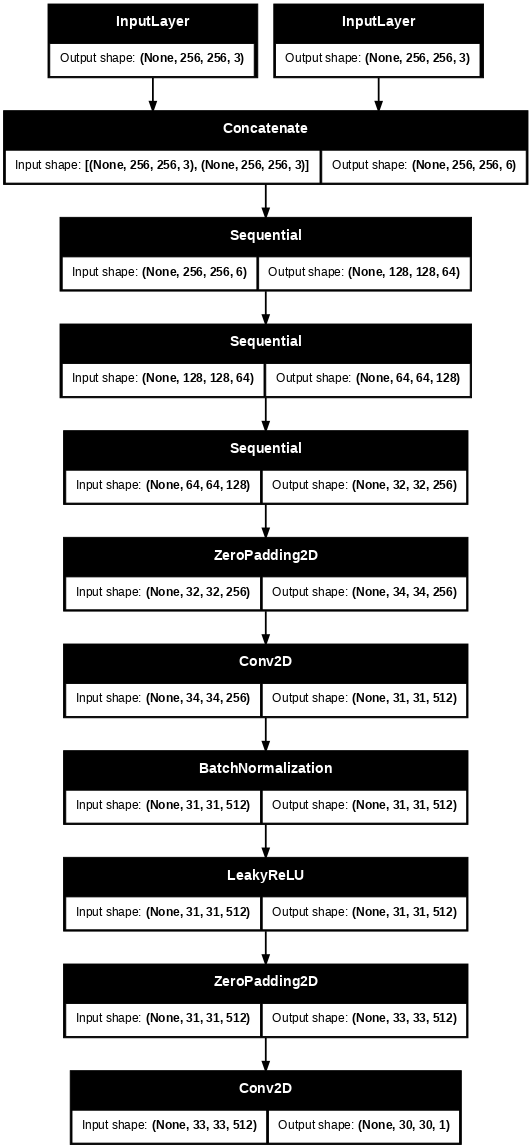

In [36]:
# Visualize the discriminator model architecture:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

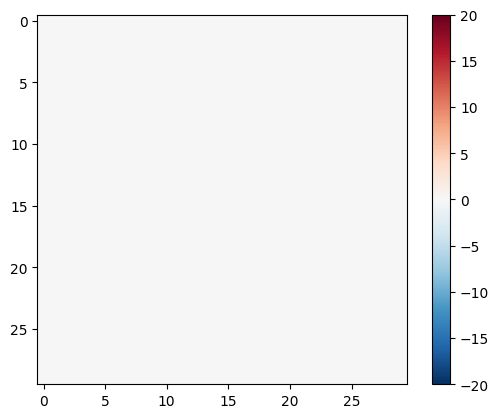

In [37]:
# Test the discriminator:
disc_out = discriminator([input_image[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ..., -1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

### **Define the discriminator loss**

- The `discriminator_loss` function takes 2 inputs: **real images and generated images**.
- `real_loss` is a sigmoid cross-entropy loss of the real images and an array of ones(since these are the real images).
- `generated_loss` is a sigmoid cross-entropy loss of the generated images and an array of zeros (since these are the fake images).
- The `total_loss` is the sum of `real_loss` and `generated_loss`.

In [38]:
def discriminator_loss(disc_real_output, disc_generated_output):
  real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

  generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

### **Define the optimizers and a checkpoint-saver**

In [39]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [40]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### **Generate Images**

- Pass images from the test set to the generator.
- The generator will then translate the input image into the output.
- The last step is to plot the predictions and voila!

In [41]:
def generate_images(model, input_image, target):
    prediction = model(input_image, training=True)

    plt.figure(figsize=(15, 15))

    display_list = [input_image[0], target[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])

        img = (display_list[i] + 1) / 2  # from [-1, 1] to [0, 1]
        img = tf.clip_by_value(img, 0.0, 1.0)  # ensure no stray values outside [0, 1]
        img = img.numpy()  # convert to NumPy array
        img = img.astype(np.float32)  # ensure compatible dtype

        plt.imshow(img)
        plt.axis('off')

    plt.show()

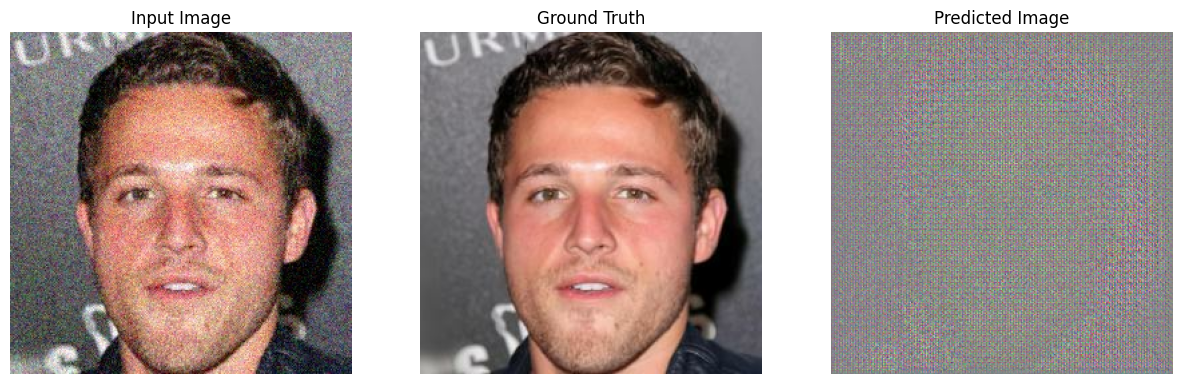

In [42]:
# Test the function:
for example_input, example_target in test_dataset.take(1):
  generate_images(generator, example_input, example_target)

### **Training**

- For each example input generates an output.
- The discriminator receives the `input_image` and the generated image as the first input. The second input is the `input_image` and the `target_image`.
- Next, calculate the generator and the discriminator loss.
- Then, calculate the gradients of loss with respect to both the generator and the discriminator variables(inputs) and apply those to the optimizer.
- Finally, log the losses to TensorBoard.

In [43]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [44]:
@tf.function
def train_step(input_image, target, step):
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    gen_output = generator(input_image, training=True)

    disc_real_output = discriminator([input_image, target], training=True)
    disc_generated_output = discriminator([input_image, gen_output], training=True)

    gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
    disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  with summary_writer.as_default():
    tf.summary.scalar('gen_total_loss', gen_total_loss, step=step//1000)
    tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step//1000)
    tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step//1000)
    tf.summary.scalar('disc_loss', disc_loss, step=step//1000)

**The actual training loop**

In [45]:
def fit(train_ds, test_ds, steps):
  example_input, example_target = next(iter(test_ds.take(1)))
  start = time.time()

  for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
    if (step) % 1000 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 1000 steps: {time.time()-start:.2f} sec\n')

      start = time.time()

      generate_images(generator, example_input, example_target)
      print(f"Step: {step//1000}k")

    train_step(input_image, target, step)

    # Training step
    if (step+1) % 10 == 0:
      print('.', end='', flush=True)


    # Save (checkpoint) the model every 10k steps
    if (step + 1) % 10000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

In [46]:
# %load_ext tensorboard
# %tensorboard --logdir {log_dir}

In [47]:
fit(train_dataset, test_dataset, steps=80000)

### **Restore the latest checkpoint and test the network**

In [48]:
checkpoint_dir = "training-checkpoints"
checkpoint = tf.train.Checkpoint(generator=generator)

# Restore the latest checkpoint
latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest_checkpoint).expect_partial()
print(f"Restored from {latest_checkpoint}")

Restored from None


In [46]:
ls {checkpoint_dir}

checkpoint                  ckpt-5.data-00000-of-00001
ckpt-1.data-00000-of-00001  ckpt-5.index
ckpt-1.index                ckpt-6.data-00000-of-00001
ckpt-2.data-00000-of-00001  ckpt-6.index
ckpt-2.index                ckpt-7.data-00000-of-00001
ckpt-3.data-00000-of-00001  ckpt-7.index
ckpt-3.index                ckpt-8.data-00000-of-00001
ckpt-4.data-00000-of-00001  ckpt-8.index
ckpt-4.index


In [47]:
# Restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### **Generate some images using the test set**

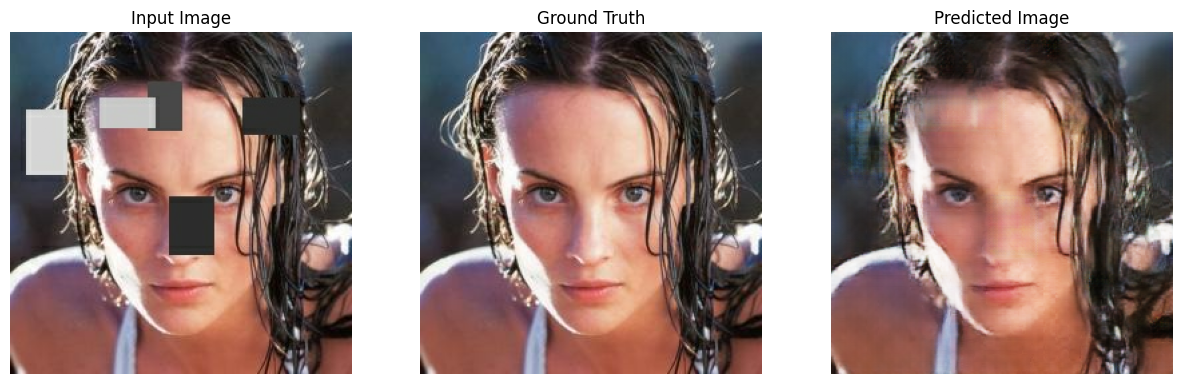

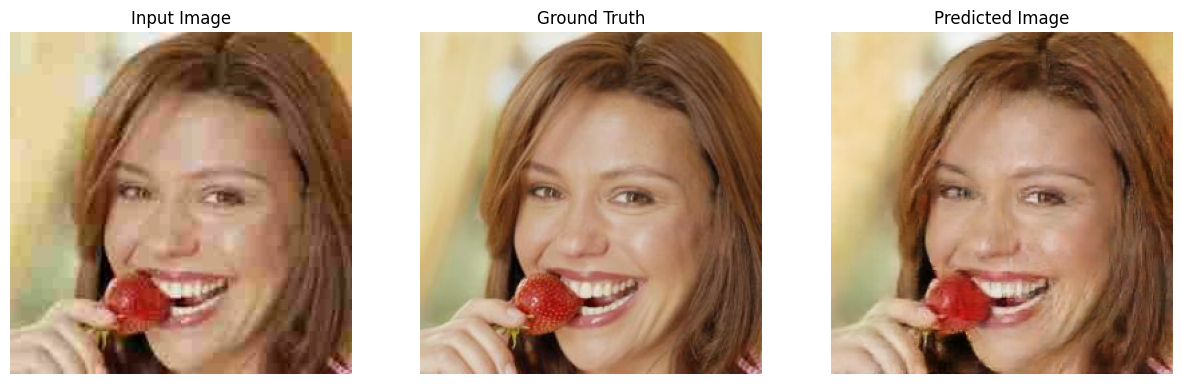

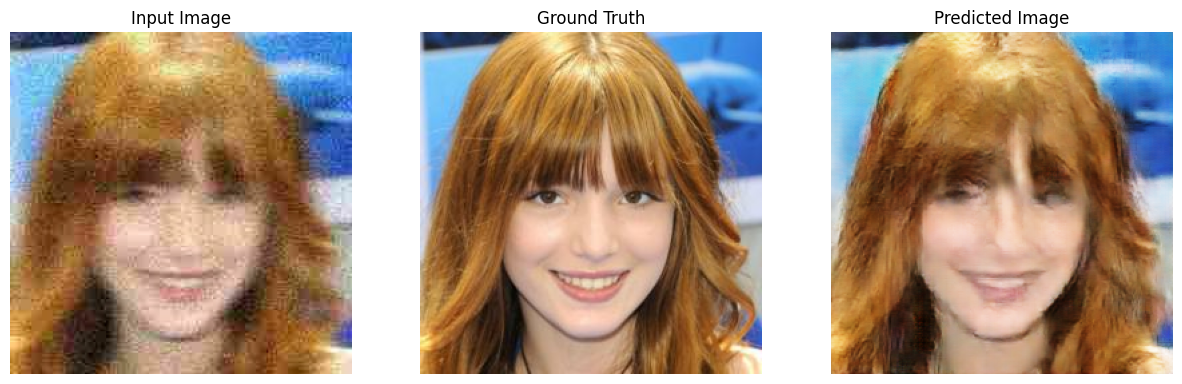

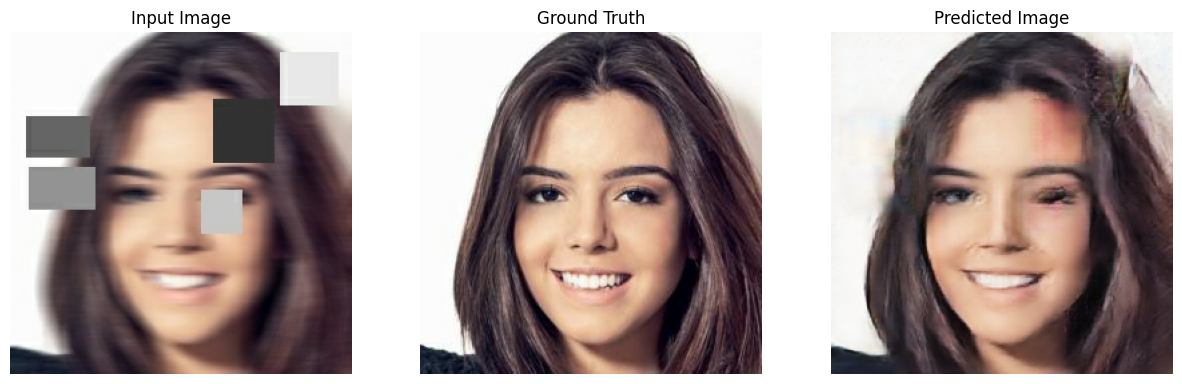

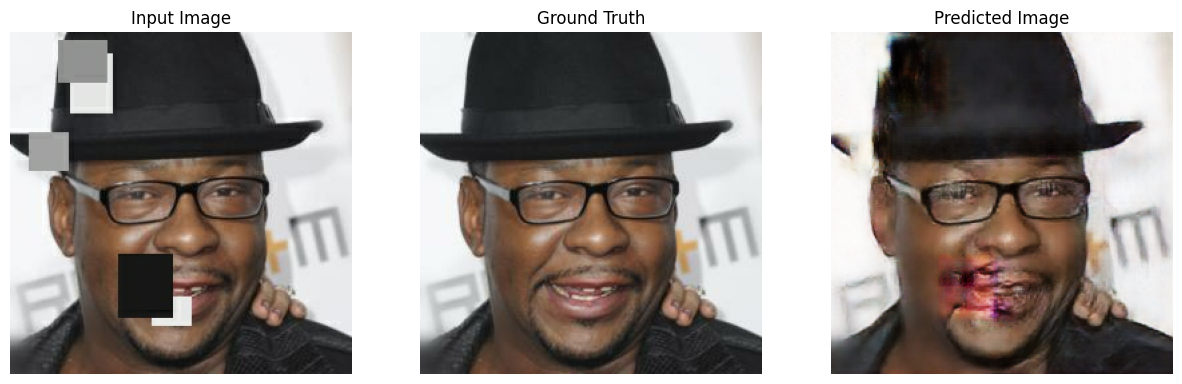

In [48]:
# Run the trained model on a few examples from the test set
for inp, tar in test_dataset.take(5):
  generate_images(generator, inp, tar)

In [49]:
!pip install lpips

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.4 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 30.7 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.9.41
    Uninstalling nvidia-nvjitlink-cu12-12.9.41:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.9.41
  Attempting uninstall: nvidia-curand-cu12
    Found existing in

In [50]:
from skimage.metrics import peak_signal_noise_ratio as PSNR
from skimage.metrics import structural_similarity as ssim
import lpips  # Learned Perceptual Image Patch Similarity

In [51]:
for degraded_image, clean_image in test_dataset.take(1):
    predicted_image = generator(degraded_image, training=False)

    print("Predicted shape:", predicted_image.shape)
    print("Ground truth shape:", clean_image.shape)
    print("Predicted min/max:", predicted_image.numpy().min(), predicted_image.numpy().max())
    print("Ground truth min/max:", clean_image.numpy().min(), clean_image.numpy().max())


Predicted shape: (1, 256, 256, 3)
Ground truth shape: (1, 256, 256, 3)
Predicted min/max: -0.9826069 0.97792715
Ground truth min/max: -1.0 1.0


In [52]:
# Remove batch dimension and rescale to [0, 1]
pred_rescaled = (predicted_image[0] + 1) / 2
gt_rescaled   = (clean_image[0] + 1) / 2

# Check again to be safe
print("Pred rescaled min/max:", pred_rescaled.numpy().min(), pred_rescaled.numpy().max())
print("GT rescaled min/max:", gt_rescaled.numpy().min(), gt_rescaled.numpy().max())


Pred rescaled min/max: 0.008696556 0.9889636
GT rescaled min/max: 0.0 1.0


In [53]:
def compute_ssim(img1, img2):
    """
    Computes SSIM between two images.
    Both should be tensors or NumPy arrays in [0, 1] with shape (H, W, C)
    """
    ssim_score = tf.image.ssim(img1, img2, max_val=1.0)
    return tf.reduce_mean(ssim_score)


In [54]:
def compute_psnr(img1, img2):
    """
    Computes PSNR between two images.
    Both should be tensors or NumPy arrays in [0, 1] with shape (H, W, C)
    """
    psnr_score = tf.image.psnr(img1, img2, max_val=1.0)
    return tf.reduce_mean(psnr_score)


In [55]:
import lpips
import torch

# Create LPIPS model (AlexNet-based)
lpips_model = lpips.LPIPS(net='alex').to('cuda')  # or 'cpu'

def compute_lpips(img1, img2):
    """
    Computes LPIPS between two images.
    img1, img2 should be NumPy arrays in [0, 1] with shape (H, W, C)
    """
    img1 = torch.tensor(img1).permute(2, 0, 1).unsqueeze(0).to('cuda') * 2 - 1  # [0,1] -> [-1,1]
    img2 = torch.tensor(img2).permute(2, 0, 1).unsqueeze(0).to('cuda') * 2 - 1

    with torch.no_grad():
        lpips_score = lpips_model(img1, img2)
    return lpips_score.item()


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 214MB/s] 


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


In [56]:
# Take one test sample (BATCH_SIZE = 1)
for degraded_image, clean_image in test_dataset.take(1):
    predicted_image = generator(degraded_image, training=False)
    ground_truth = clean_image

In [57]:
ssim_val = compute_ssim(pred_rescaled, gt_rescaled)
psnr_val = compute_psnr(pred_rescaled, gt_rescaled)
lpips_val = compute_lpips(predicted_image[0].numpy(), clean_image[0].numpy())

In [58]:
print (f"Structural Similarity Index Measure (SSIM): {ssim_val}")
print (f"Peak Signal-to-Noise Ratio (PSNR): {psnr_val}")
print (f"Learned Perceptual Image Patch Similarity (LPIPS): {lpips_val}")

Structural Similarity Index Measure (SSIM): 0.6349563598632812
Peak Signal-to-Noise Ratio (PSNR): 18.56854820251465
Learned Perceptual Image Patch Similarity (LPIPS): 0.2788145840167999


In [ ]:
# new_test_clean= '/kaggle/input/clean-images'
# new_test_degraded= '/kaggle/input/degraded-images'

In [ ]:
# new_test = tf.data.Dataset.from_tensor_slices((test_degraded_images, test_clean_images))
# new_test = new_test.map(load_image_test_tf, num_parallel_calls=tf.data.AUTOTUNE)
# new_test = new_test.batch(BATCH_SIZE)

In [ ]:
# # Run the trained model on a few examples from the test set
# for inp, tar in test_dataset.take(5):
#   generate_images(generator, inp, tar)

In [59]:
!apt-get install zip -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
zip is already the newest version (3.0-12build2).
0 upgraded, 0 newly installed, 0 to remove and 87 not upgraded.
